In [6]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import category_encoders
import missingno
import boruta
import tsfresh
import sktime
import statsmodels
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import re

In [7]:
lab_data = pd.read_csv('C:/Users/u840716/Anna Thesis/Data/thesis_lab_data.csv')

In [8]:
# Total number of rows in lab_data
total_rows = lab_data.shape[0]

# Count unique patients
unique_patients = lab_data["PatID"].nunique()

# Count VT and Control patients
vt_count = lab_data[lab_data["PatID"].str.startswith("VT")]["PatID"].nunique()
control_count = lab_data[lab_data["PatID"].str.startswith("C")]["PatID"].nunique()

print(f"Total rows in lab_data: {total_rows}")
print(f"Total unique patients: {unique_patients}")
print(f"VT patients: {vt_count}")
print(f"Control patients: {control_count}")

Total rows in lab_data: 1753143
Total unique patients: 2771
VT patients: 118
Control patients: 2653


In [9]:
# Count unique test types
unique_tests = lab_data["Oms_Code"].nunique()


print(f"Total unique tests (Oms_Code): {unique_tests}")

Total unique tests (Oms_Code): 472


In [10]:
unique_groep_oms = lab_data["GroepOms"].nunique()
print(f"Number of unique values in 'GroepOms': {unique_groep_oms}")


Number of unique values in 'GroepOms': 24


In [11]:
unique_values_groep_oms = lab_data["GroepOms"].unique()
print(f"Unique values in 'GroepOms': {unique_values_groep_oms}")

Unique values in 'GroepOms': ['Hematologie' 'Chemie' 'Endocrinologie' 'Urineportie' 'Stolling'
 'Bloedgassen' '24h urine' 'Immunologie' 'Overig lichaamsvocht'
 'Bloedtransfusie' 'Diversen' 'Opmerking' 'Glucose (POCT)' 'Tumormarkers'
 'Feces' nan 'Allergie' 'Dna onderzoek' 'Geneesmiddelspiegels'
 'Pleuravocht' 'Beenmerg' 'Dialysaat' 'Immunofenotypering' 'Liquor'
 'Drainvocht']


Removing the data that was outside of the desired dates (before infarction per patient, and after end date per patient)

In [12]:
first_last_MIdate = pd.read_csv('C:/Users/u840716/Anna Thesis/Data/PatientSelection_COMBATVT23_Anon_IntermediateAnna.csv', sep=";")
#last_dates_DBC = pd.read_csv('Data\LastDatesWithDBC.csv')

In [13]:
# Date columns in datetime format
lab_data["Date (s)"] = pd.to_datetime(lab_data["Date (s)"], dayfirst=False, errors="coerce")
first_last_MIdate["First MI date (s)"] = pd.to_datetime(first_last_MIdate["First MI date (s)"], dayfirst=True, errors="coerce")
first_last_MIdate["Last Date (s)"] = pd.to_datetime(first_last_MIdate["Last Meas Date (s)"], dayfirst=True, errors="coerce")
first_last_MIdate["First VT date (s)"]    = pd.to_datetime(first_last_MIdate["First VT date (s)"], dayfirst=True, errors="coerce")

# Merge in all three date columns
lab_data = (
    lab_data
    .merge(first_last_MIdate[["PatID", "First MI date (s)", "Last Date (s)", "First VT date (s)"]],
           on="PatID", how="left")
)

# Per‐row “upper bound” date: for VT IDs use the VT date, otherwise use the last date
lab_data["Upper Date (s)"] = np.where(
    lab_data["PatID"].str.startswith("VT"),
    lab_data["First VT date (s)"],
    lab_data["Last Date (s)"]
)

# Filter to only those tests that are between First MI and the appropriate upper bound
lab_data_correct_dates = lab_data[
    (lab_data["Date (s)"] >= lab_data["First MI date (s)"]) &
    (lab_data["Date (s)"] <= lab_data["Upper Date (s)"])
].copy()

# keeping dropped ones in case
removed_tests = lab_data[
    (lab_data["Date (s)"] <  lab_data["First MI date (s)"]) |
    (lab_data["Date (s)"] >  lab_data["Upper Date (s)"])
].copy()

# Drop the merged date‐columns that are not needed
lab_data_correct_dates.drop(
    columns=["Last Date (s)", "First VT date (s)"],
    inplace=True
)

# Quick counts
print(f"Kept {len(lab_data_correct_dates)} tests; removed {len(removed_tests)} outside valid windows.")


C:\Users\u840716\AppData\Local\Temp\5\ipykernel_11748\3599890116.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  first_last_MIdate["First VT date (s)"]    = pd.to_datetime(first_last_MIdate["First VT date (s)"], dayfirst=True, errors="coerce")


Kept 1477158 tests; removed 275985 outside valid windows.


In [14]:
# Total number of rows in lab_data
total_rows = lab_data_correct_dates.shape[0]


# Count VT and Control patients
vt_count = lab_data_correct_dates[lab_data_correct_dates["PatID"].str.startswith("VT")]["PatID"].nunique()
control_count = lab_data_correct_dates[lab_data_correct_dates["PatID"].str.startswith("C")]["PatID"].nunique()
# Print results
print(f"Total rows in lab_data: {total_rows}")
print(f"Total unique patients: {unique_patients}")
print(f"VT patients: {vt_count}")
print(f"Control patients: {control_count}")

# Count unique test types
unique_tests = lab_data_correct_dates["Oms_Code"].nunique()

# Print result
print(f"Total unique tests (Oms_Code): {unique_tests}")

Total rows in lab_data: 1477158
Total unique patients: 2771
VT patients: 111
Control patients: 2641
Total unique tests (Oms_Code): 462


Keep only the tests that have status "Corrected" or "Validated"

In [15]:
# Total rows before filtering
initial_count = len(lab_data_correct_dates)

# Filter the DataFrame
lab_data_correct_status = lab_data_correct_dates[lab_data_correct_dates["StatusOms"].isin(["Gecorrigeerd", "Gevalideerd"])].copy()

# Total rows after filtering
status_filter_count = len(lab_data_correct_status)

# Rows removed
rows_removed = initial_count - status_filter_count

# Print results
print(f"Initial number of rows: {initial_count}")
print(f"Number of rows after filtering: {status_filter_count}")
print(f"Number of rows removed: {rows_removed}")

Initial number of rows: 1477158
Number of rows after filtering: 1476364
Number of rows removed: 794


In [16]:
# Total number of rows in lab_data
total_rows = lab_data_correct_status.shape[0]


# Count VT and Control patients
vt_count = lab_data_correct_status[lab_data_correct_status["PatID"].str.startswith("VT")]["PatID"].nunique()
control_count = lab_data_correct_status[lab_data_correct_status["PatID"].str.startswith("C")]["PatID"].nunique()
# Print results
print(f"Total rows in lab_data: {total_rows}")
print(f"Total unique patients: {unique_patients}")
print(f"VT patients: {vt_count}")
print(f"Control patients: {control_count}")

# Count unique test types
unique_tests = lab_data_correct_dates["Oms_Code"].nunique()

# Print result
print(f"Total unique tests (Oms_Code): {unique_tests}")

Total rows in lab_data: 1476364
Total unique patients: 2771
VT patients: 111
Control patients: 2641
Total unique tests (Oms_Code): 462


### Cleaning results and columns

In [17]:
# Identify all 'LabAanvraagBronKey' values where the result is 'ip fout'
ip_fout_keys = lab_data_correct_status.loc[
    lab_data_correct_status['Uitslag'].str.lower().str.strip() == 'ip fout',
    'LabAanvraagBronKey'
].unique()

# Remove all rows that share those LabAanvraagBronKey values
lab_data_cleaned = lab_data_correct_status[~lab_data_correct_status['LabAanvraagBronKey'].isin(ip_fout_keys)].copy()


removed_rows = lab_data_correct_status.shape[0] - lab_data_cleaned.shape[0]
print(f"Removed {removed_rows} rows due to 'ip fout' lab requests.")


Removed 0 rows due to 'ip fout' lab requests.


In [18]:
# Show all rows where 'Uitslag' contains the word 'fout' (case-insensitive)
fout_rows = lab_data_correct_status[lab_data_correct_status['Uitslag'].str.contains('fout', case=False, na=False)]


print(f"Found {len(fout_rows)} rows where 'Uitslag' contains 'fout':")
display(fout_rows[['PatID', 'BepalingCode', 'Uitslag', 'LabAanvraagBronKey']].head(20))


Found 5 rows where 'Uitslag' contains 'fout':


,PatID,BepalingCode,Uitslag,LabAanvraagBronKey
51196,C2727,CS000086,fout mat,9244567
51240,C2727,CS002108,fout mat,9244567
384903,C609,CS000495,fout mat,9147167
384904,C609,CS000497,fout mat,9147167
384906,C609,CS000504,fout mat,9147167


In [19]:
lab_data_correct_status["Group"] = lab_data_correct_status["PatID"].str.startswith("VT").map({True: "VT", False: "Control"})
lab_data_correct_status["Group"].value_counts()

Group
Control    1400232
VT           76132
Name: count, dtype: int64

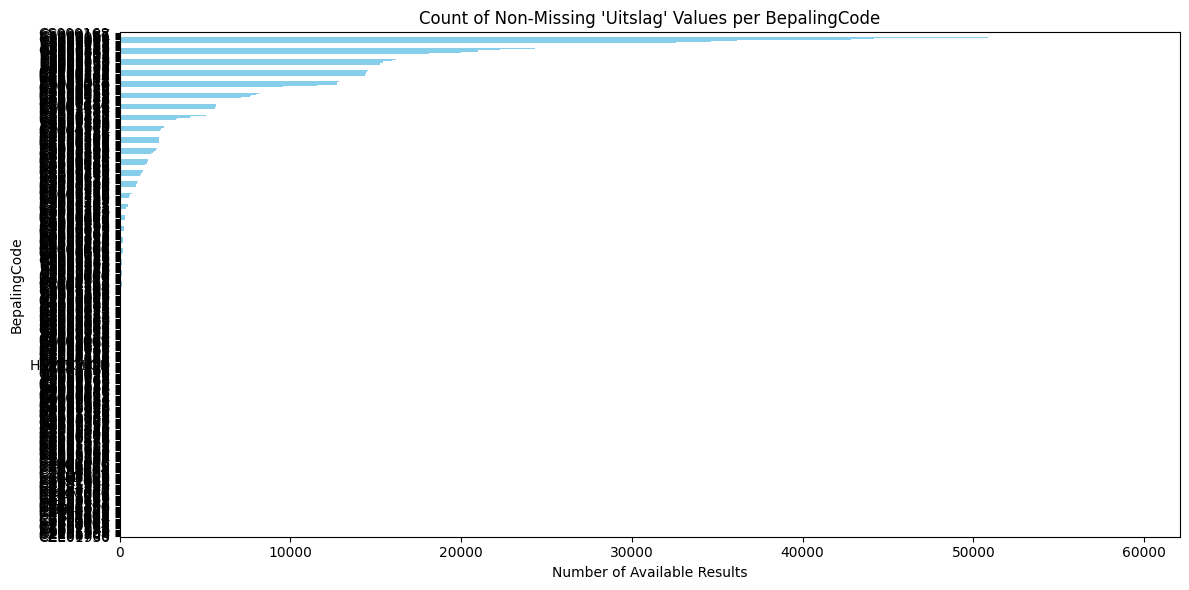

In [20]:
# Convert "Uitslag" column to NaN if it's empty string or placeholder
lab_data_correct_status["Uitslag"] = lab_data_correct_status["Uitslag"].replace(["", " ", "nan", "NaN", None], pd.NA)

# Pivot table of counts of Uitslag values per test
missing_summary = lab_data_correct_status.groupby('BepalingCode')['Uitslag'].apply(lambda x: x.notna().sum()).sort_values()

# Plot the missingness as a bar chart
plt.figure(figsize=(12, 6))
missing_summary.plot(kind='barh', color='skyblue')
plt.title("Count of Non-Missing 'Uitslag' Values per BepalingCode")
plt.xlabel("Number of Available Results")
plt.ylabel("BepalingCode")
plt.tight_layout()
plt.show()

In [21]:
# Count how many patients have a result per test
test_counts = lab_data_correct_status.dropna(subset=['Uitslag']) \
    .groupby('BepalingCode')['PatID'].nunique().sort_values(ascending=False)

# View a few examples
test_counts.tail(10)


BepalingCode
CZE02242    1
BAM001      1
CZE01288    1
CZE01304    1
CZE00700    1
CS001145    1
CS001642    1
CS001529    1
CS001036    1
CZE01930    1
Name: PatID, dtype: int64

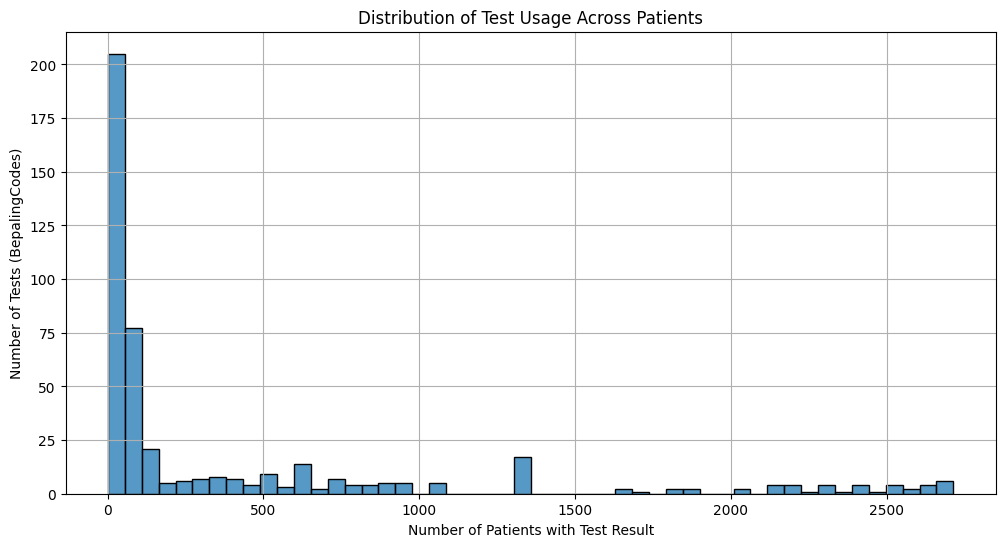

In [22]:


plt.figure(figsize=(12, 6))
sns.histplot(test_counts, bins=50, kde=False)
plt.xlabel('Number of Patients with Test Result')
plt.ylabel('Number of Tests (BepalingCodes)')
plt.title('Distribution of Test Usage Across Patients')
plt.grid(True)
plt.show()


<Figure size 1400x600 with 0 Axes>

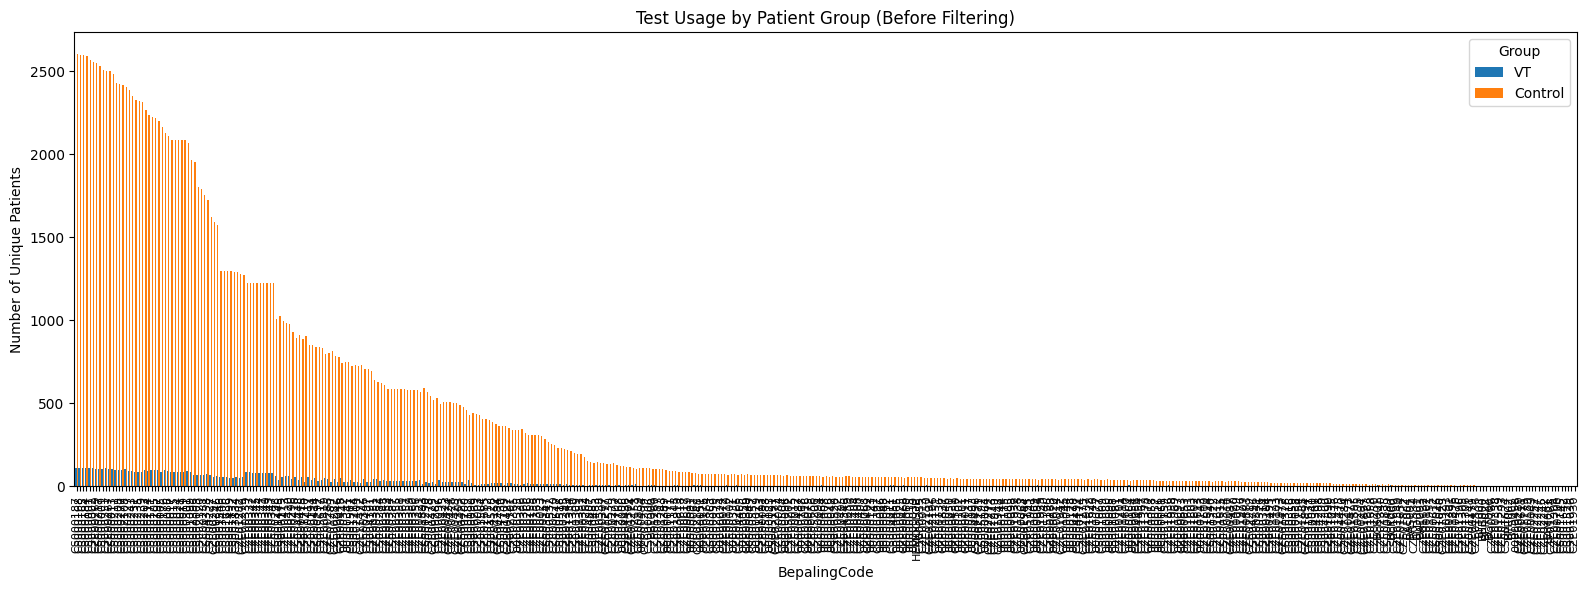

In [23]:


# Count unique patients per test and group
test_group_counts = (
    lab_data_correct_status
    .groupby(["BepalingCode", "Group"])["PatID"]
    .nunique()
    .reset_index()
    .pivot(index="BepalingCode", columns="Group", values="PatID")
    .fillna(0)
)

# Sort by total patients (VT + Control)
test_group_counts["Total"] = test_group_counts.sum(axis=1)
test_group_counts = test_group_counts.sort_values("Total", ascending=False)


plt.figure(figsize=(14, 6))
test_group_counts[["VT", "Control"]].plot(kind="bar", stacked=False, figsize=(16, 6), width=0.8)
plt.title("Test Usage by Patient Group (Before Filtering)")
plt.xlabel("BepalingCode")
plt.ylabel("Number of Unique Patients")
plt.xticks(rotation=90, fontsize=8)
plt.legend(title="Group")
plt.tight_layout()
plt.show()


In [24]:
# Keep tests used in at least 100 patients
threshold = 100  # or try different values based on the plot
tests_to_keep = test_counts[test_counts >= threshold].index

# Filter your data
lab_data_filtered_tests = lab_data_correct_status[lab_data_correct_status['BepalingCode'].isin(tests_to_keep)]

print(f"Tests kept: {len(tests_to_keep)} / {test_counts.shape[0]}")
print(f"Rows remaining: {lab_data_filtered_tests.shape[0]} / {lab_data_correct_status.shape[0]}")


Tests kept: 180 / 459
Rows remaining: 1455461 / 1476364


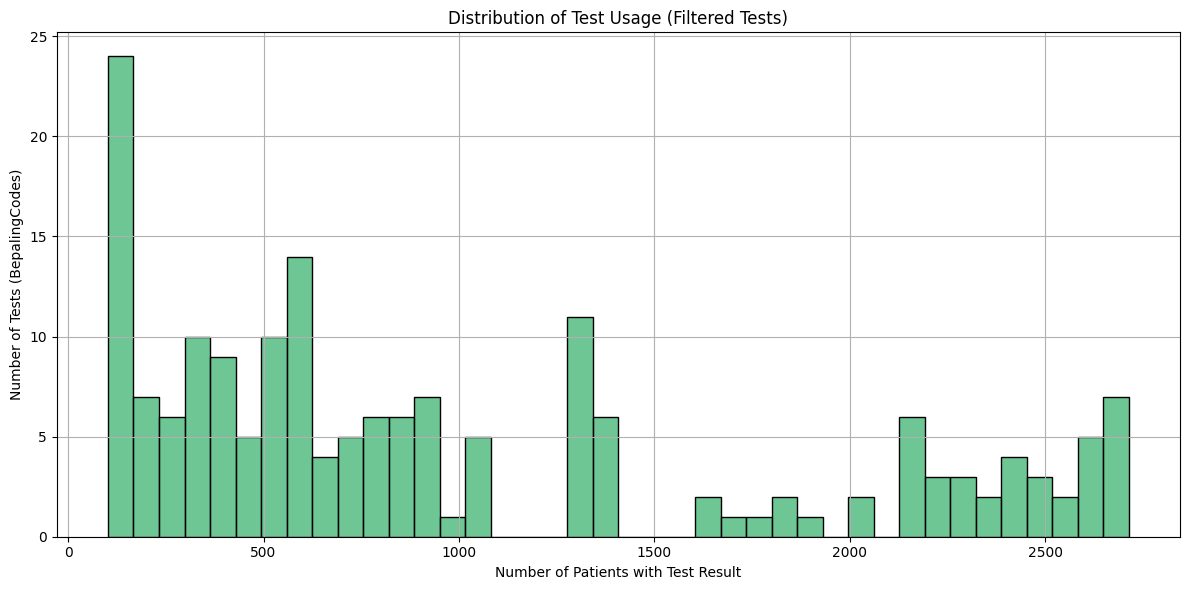

In [25]:
# Recalculate patient counts per test in the filtered data
filtered_test_counts = lab_data_filtered_tests.dropna(subset=['Uitslag']) \
    .groupby('BepalingCode')['PatID'].nunique().sort_values(ascending=False)


plt.figure(figsize=(12, 6))
sns.histplot(filtered_test_counts, bins=40, kde=False, color="mediumseagreen")
plt.xlabel('Number of Patients with Test Result')
plt.ylabel('Number of Tests (BepalingCodes)')
plt.title('Distribution of Test Usage (Filtered Tests)')
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 1400x600 with 0 Axes>

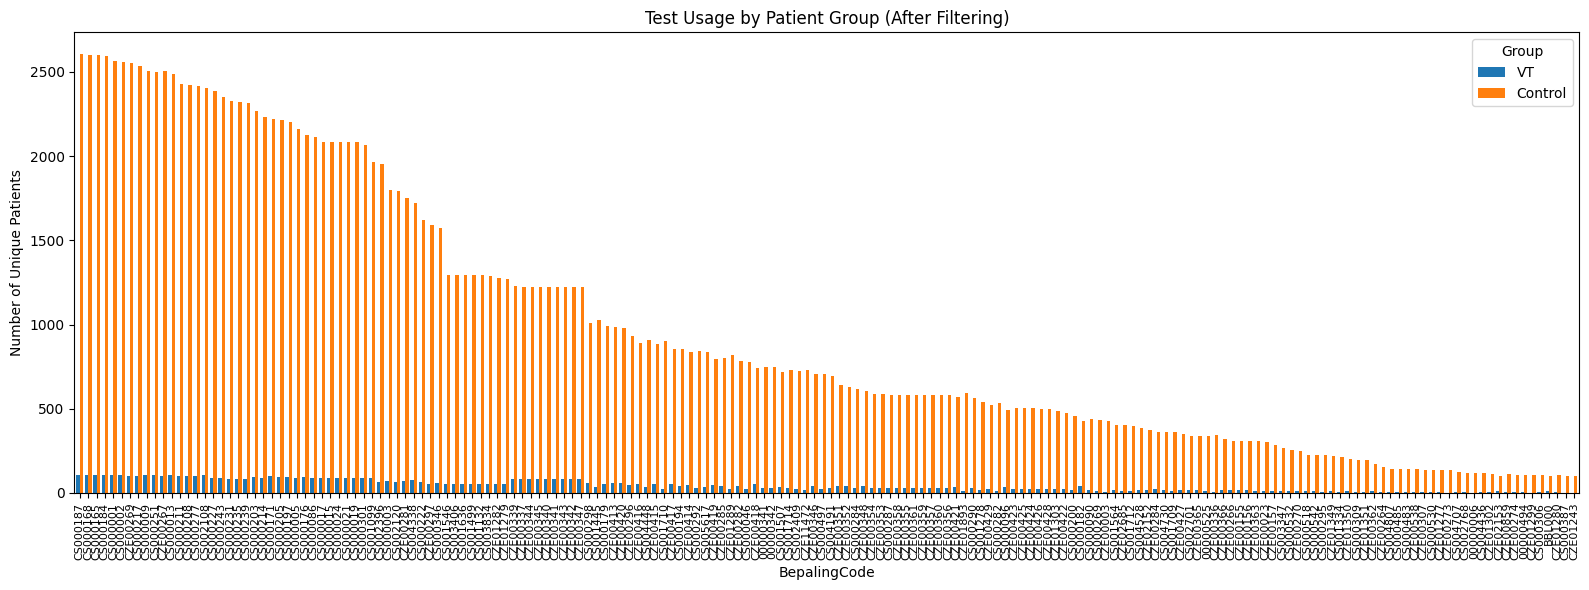

In [26]:
# Count unique patients per test and group (after filtering)
filtered_test_group_counts = (
    lab_data_filtered_tests
    .groupby(["BepalingCode", "Group"])["PatID"]
    .nunique()
    .reset_index()
    .pivot(index="BepalingCode", columns="Group", values="PatID")
    .fillna(0)
)

# Sort 
filtered_test_group_counts["Total"] = filtered_test_group_counts.sum(axis=1)
filtered_test_group_counts = filtered_test_group_counts.sort_values("Total", ascending=False)


plt.figure(figsize=(14, 6))
filtered_test_group_counts[["VT", "Control"]].plot(kind="bar", stacked=False, figsize=(16, 6), width=0.8)
plt.title("Test Usage by Patient Group (After Filtering)")
plt.xlabel("BepalingCode")
plt.ylabel("Number of Unique Patients")
plt.xticks(rotation=90, fontsize=8)
plt.legend(title="Group")
plt.tight_layout()
plt.show()


In [27]:
# Total number of rows in lab_data
total_rows = lab_data_filtered_tests.shape[0]


# Count VT and Control patients
vt_count = lab_data_filtered_tests[lab_data_filtered_tests["PatID"].str.startswith("VT")]["PatID"].nunique()
control_count = lab_data_filtered_tests[lab_data_filtered_tests["PatID"].str.startswith("C")]["PatID"].nunique()

print(f"Total rows in lab_data: {total_rows}")
print(f"Total unique patients: {unique_patients}")
print(f"VT patients: {vt_count}")
print(f"Control patients: {control_count}")

# Count unique test types
unique_tests = lab_data_filtered_tests["Oms_Code"].nunique()


print(f"Total unique tests (Oms_Code): {unique_tests}")

Total rows in lab_data: 1455461
Total unique patients: 2771
VT patients: 111
Control patients: 2639
Total unique tests (Oms_Code): 181


In [28]:
# Remove rows where Oms_Code is "Glucose (POCT)"
df_filtered = lab_data_filtered_tests[lab_data_filtered_tests["GroepOms"] != "Glucose (POCT)"]


In [29]:
# Remove rows where Oms_Code starts with "Aantal EC's"
df_filtered = df_filtered[~df_filtered["Oms_Code"].str.startswith("Aantal EC's", na=False)]


In [30]:
# Get unique combinations of Oms_Code, GroepOms, BepalingCode, and Eenheid
unique_combinations = df_filtered[["Oms_Code", "GroepOms", "BepalingCode", "Eenheid"]].drop_duplicates().sort_values("Oms_Code")

# Print count and values
print(f"Number of unique Oms_Code values remaining: {unique_combinations['Oms_Code'].nunique()}\n")
print("Remaining Oms_Codes with details:")
for _, row in unique_combinations.iterrows():
    print(f"- {row['Oms_Code']} ({row['GroepOms']}) | Code: {row['BepalingCode']} | Unit: {row['Eenheid']}")


Number of unique Oms_Code values remaining: 177

Remaining Oms_Codes with details:
- ALAT_CS000211 (Chemie) | Code: CS000211 | Unit: U/L
- APTT_CS000090 (Stolling) | Code: CS000090 | Unit: sec
- APTT_CS004338 (Stolling) | Code: CS004338 | Unit: sec.
- ASAT_CS000208 (Chemie) | Code: CS000208 | Unit: U/L
- Albumine (u)_CS004191 (Urineportie) | Code: CS004191 | Unit: mg/L
- Albumine/kreatinine_CZE01303 (Urineportie) | Code: CZE01303 | Unit: mg/mmol
- Albumine_CS000301 (Chemie) | Code: CS000301 | Unit: g/L
- Albumine_CZE01350 (24h urine) | Code: CZE01350 | Unit: mg/L
- Albumine_CZE01351 (24h urine) | Code: CZE01351 | Unit: mg/24 u
- Alkalische Fosfatase (AF)_CS000203 (Chemie) | Code: CS000203 | Unit: U/L
- Amylase_CS000222 (Chemie) | Code: CS000222 | Unit: U/L
- Amylase_CZE01299 (Urineportie) | Code: CZE01299 | Unit: U/L
- Anion gap_CZE00421 (Bloedgassen) | Code: CZE00421 | Unit: mmol/L
- Anti-MPO_CS000387 (Immunologie) | Code: CS000387 | Unit: IU/mL
- Anti-TTG IgA_CZE00538 (Immunologie) |

In [31]:
# Sorted unique Oms_Code values
remaining_oms_codes = sorted(lab_data_filtered_tests["Oms_Code"].dropna().unique())

for code in remaining_oms_codes:
    print(code)


ALAT_CS000211
APTT_CS000090
APTT_CS004338
ASAT_CS000208
Aantal EC's getransfundeerd deze order_CZE00155
Aantal EC's uitgegeven deze order_CZE00156
Aantal EC's van deze order op voorraad_CZE00157
Albumine (u)_CS004191
Albumine/kreatinine_CZE01303
Albumine_CS000301
Albumine_CZE01350
Albumine_CZE01351
Alkalische Fosfatase (AF)_CS000203
Amylase_CS000222
Amylase_CZE01299
Anion gap_CZE00421
Anti-MPO_CS000387
Anti-TTG IgA_CZE00538
BBL000
Bacterien_CZE01289
Base excess_CZE00344
Base excess_CZE00359
Basofielen_CS000024
Bezinking_CS001099
Bicarbonaat_CZE00343
Bicarbonaat_CZE00358
Bilirubine Direct_CS000200
Bilirubine Totaal_CS000197
Bilirubine_CS001132
Bloedgasanalyse arterieel_CZE00337
Bloedgasanalyse veneus_CZE00353
Bloedgroep_00000341
C-troponine-I_CZE00285
CK-MB massa_CZE00284
CK-MB_CZE00267
CK_CS000217
CRP (POC)_CZE00273
CRP-HiSence_CS002701
CRP_CS000277
CS004707
Ca (alb. Correct)_CS004730
Calcium ionen_CZE00419
Calcium ionen_CZE00428
Calcium_CS000176
Carboxyhemoglobine_CZE00351
Carboxyhemo

In [32]:
# Remove rows with ExternalCode starting with 'X' or 'x'
df_filtered = df_filtered[~df_filtered["ExternalCode"].str.startswith(('X', 'x'), na=False)]


In [33]:
# Remove rows where Uitslag contains unwanted strings
# Lowercase everything to catch any variations
unwanted_keywords = ["fout", "verv", "te weinig materiaal", "mng", "icter"]

# Define regex pattern (case-insensitive)
pattern = '|'.join(unwanted_keywords)

# Remove rows matching pattern
df_filtered = df_filtered[~df_filtered["Uitslag"].str.lower().str.contains(pattern, na=False)]


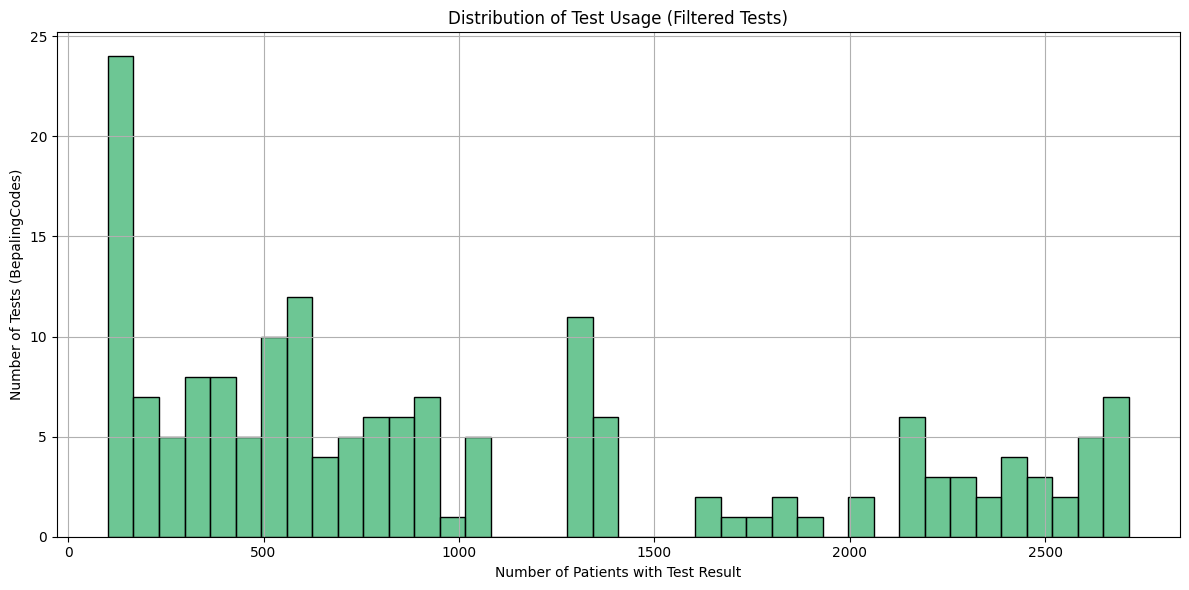

In [34]:
# Recalculate patient counts per test 
filtered_test_counts_2 = df_filtered.dropna(subset=['Uitslag']) \
    .groupby('BepalingCode')['PatID'].nunique().sort_values(ascending=False)


plt.figure(figsize=(12, 6))
sns.histplot(filtered_test_counts_2, bins=40, kde=False, color="mediumseagreen")
plt.xlabel('Number of Patients with Test Result')
plt.ylabel('Number of Tests (BepalingCodes)')
plt.title('Distribution of Test Usage (Filtered Tests)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
# Get sorted unique Oms_Code values
remaining_oms_codes = sorted(df_filtered["Oms_Code"].dropna().unique())


for code in remaining_oms_codes:
    print(code)

ALAT_CS000211
APTT_CS000090
APTT_CS004338
ASAT_CS000208
Albumine (u)_CS004191
Albumine/kreatinine_CZE01303
Albumine_CS000301
Albumine_CZE01350
Albumine_CZE01351
Alkalische Fosfatase (AF)_CS000203
Amylase_CS000222
Amylase_CZE01299
Anion gap_CZE00421
Anti-MPO_CS000387
Anti-TTG IgA_CZE00538
BBL000
Bacterien_CZE01289
Base excess_CZE00344
Base excess_CZE00359
Basofielen_CS000024
Bezinking_CS001099
Bicarbonaat_CZE00343
Bicarbonaat_CZE00358
Bilirubine Direct_CS000200
Bilirubine Totaal_CS000197
Bilirubine_CS001132
Bloedgasanalyse arterieel_CZE00337
Bloedgasanalyse veneus_CZE00353
Bloedgroep_00000341
C-troponine-I_CZE00285
CK-MB massa_CZE00284
CK-MB_CZE00267
CK_CS000217
CRP (POC)_CZE00273
CRP-HiSence_CS002701
CRP_CS000277
CS004707
Ca (alb. Correct)_CS004730
Calcium ionen_CZE00419
Calcium ionen_CZE00428
Calcium_CS000176
Carboxyhemoglobine_CZE00351
Carboxyhemoglobine_CZE00365
Chloride_CS000171
Chloride_CZE00418
Chloride_CZE00427
Cholesterol-HDL Ratio_CS000235
Cholesterol_CS000227
Colab score_0000

In [36]:
# Total number of rows in lab_data
total_rows = df_filtered.shape[0]


# Count VT and Control patients
vt_count = df_filtered[df_filtered["PatID"].str.startswith("VT")]["PatID"].nunique()
control_count = df_filtered[df_filtered["PatID"].str.startswith("C")]["PatID"].nunique()
# Print results
print(f"Total rows in lab_data: {total_rows}")
print(f"Total unique patients: {unique_patients}")
print(f"VT patients: {vt_count}")
print(f"Control patients: {control_count}")

# Count unique test types
unique_tests = df_filtered["Oms_Code"].nunique()

# Print result
print(f"Total unique tests (Oms_Code): {unique_tests}")

Total rows in lab_data: 1441732
Total unique patients: 2771
VT patients: 111
Control patients: 2635
Total unique tests (Oms_Code): 175


In [37]:
df = df_filtered.copy()

# Function to check if a value is a number and convert it
def convert_to_float(value):
    if pd.isna(value):  # Keep NaN as is
        return value
    value = str(value).strip()  # Ensure it's a string and remove spaces

    # Regular expression to check if the value is a number (including decimals and negatives)
    if value.replace('.', '', 1).replace('-', '', 1).isdigit():  
        return float(value)  # Convert to float if it's numeric
    else:
        return value  # Keep text values as they are

# Apply function to the results column
df["Uitslag"] = df["Uitslag"].apply(convert_to_float)


print(df["Uitslag"].apply(type).value_counts())  # See how many are float vs string
print(df.head())  # View sample data

Uitslag
<class 'float'>    1440916
<class 'str'>          816
Name: count, dtype: int64
     Unnamed: 0  LabAanvraagBronKey   Date (s) Spoed Uitslag BepalingCode  \
237         237             6520713 2004-09-03     J     7.8     CS000001   
238         238             7481893 2004-09-03     J     7.7     CS000001   
239         239             7481893 2004-09-03     J    0.37     CS000002   
240         240             6520713 2004-09-03     J    0.37     CS000002   
241         241             6520713 2004-09-03     J   222.0     CS000009   

     BepalingOms  Eenheid  Groep     GroepOms  ...    StatusOms GrensFlag  \
237  Hemoglobine   mmol/L    1.0  Hematologie  ...  Gevalideerd         0   
238  Hemoglobine   mmol/L    1.0  Hematologie  ...  Gevalideerd         0   
239  Hematocriet      L/L    1.0  Hematologie  ...  Gevalideerd         0   
240  Hematocriet      L/L    1.0  Hematologie  ...  Gevalideerd         0   
241  Trombocyten  x10^9/L    1.0  Hematologie  ...  Gevalideerd 

In [38]:
def classify_and_convert_results(df):
    df = df.copy()

    def parse_value(val):
        val_str = str(val).strip()
        if re.fullmatch(r'^-?\d*\.?\d+$', val_str):
            return float(val_str), 'float'
        else:
            return val, 'string'

    df[["Parsed_Uitslag", "ResultType"]] = df["Uitslag"].apply(lambda x: pd.Series(parse_value(x)))

    return df

# Apply to dataframe
df_floats = classify_and_convert_results(df)

In [39]:
# Function to check if a value is a number (including negative and decimal numbers)
def is_number(value):
    try:
        float(value)  # Try converting to float
        return True
    except ValueError:
        return False

# Identify rows where "Uitslag" is NOT numeric
df_floats["is_numeric"] = df_floats["Uitslag"].astype(str).apply(is_number)

# Filter for tests that contain text results
text_results = df_floats[~df_floats["is_numeric"]]

# Show the unique test codes that contain text values
print("Tests that contain text values:")
print(text_results["BepalingCode"].unique())

Tests that contain text values:
['00000525' 'BBL000' 'CZE01243' 'CZE00348' 'CS001132' 'CS000208'
 'CS000211' 'CZE00337' 'CS001099' 'CZE00362' 'CZE00273']


In [40]:
# Replace neg/pos with -1/1
df_floats["Uitslag"] = df_floats["Uitslag"].replace({"NEG": -1, "(neg)": -1, "POS": 1, "(pos)": 1})


In [41]:
df_floats["Uitslag"] = df_floats["Uitslag"].replace({"pos (3+)": 3, "pos (2+)": 2, "55#": 55.0, "44#" : 44.0})


In [42]:
# Filter out the two unwanted cases for CZE00273
df_floats = df_floats[~(df_floats["Uitslag"].str.lower().isin(["crp 10", "cze"]))]


In [43]:
# Drop these tests as they do not have results or are not suitable
df_floats = df_floats[~df_floats["BepalingCode"].isin(["BBL000", "CZE00348", "CZE00337", "CZE00362"])]


In [44]:
# Filter out the two unwanted cases for CS001099
df_floats = df_floats[~((df_floats["Uitslag"].str.lower().isin(["zie commentaar"])))]

In [45]:
import re

def is_numeric(value):
    try:
        float(value)
        return True
    except:
        return False

def print_result_counts(df, bepaling_code):
    # Filter by BepalingCode
    subset = df[df["BepalingCode"] == bepaling_code].copy()

    if subset.empty:
        print(f"No results found for BepalingCode {bepaling_code}.")
        return

    # Separate numeric and string results
    subset["IsNumeric"] = subset["Uitslag"].apply(is_numeric)

    # Numeric results
    numeric_results = subset[subset["IsNumeric"] == True]
    if not numeric_results.empty:
        print(f"\n Numeric results for BepalingCode {bepaling_code}:\n")
        numeric_counts = numeric_results["Uitslag"].astype(float).value_counts().sort_index()
        for result, count in numeric_counts.items():
            print(f"{result}: {count} time(s)")
    else:
        print(f"\nℹ️ No numeric results for BepalingCode {bepaling_code}.")

    # Textual results
    text_results = subset[subset["IsNumeric"] == False]
    if not text_results.empty:
        print(f"\n Text results for BepalingCode {bepaling_code}:\n")
        text_counts = text_results["Uitslag"].value_counts()
        for result, count in text_counts.items():
            print(f" {result}: {count} time(s)")
    else:
        print(f"\n No text results for BepalingCode {bepaling_code}.")


In [46]:

print_result_counts(df_floats, "CS000211")  # Replace with a code from list


 Numeric results for BepalingCode CS000211:

2.0: 1 time(s)
3.0: 2 time(s)
4.5: 33 time(s)
5.0: 1 time(s)
5.1: 1 time(s)
5.2: 3 time(s)
5.3: 6 time(s)
5.4: 5 time(s)
5.5: 3 time(s)
5.6: 1 time(s)
5.7: 6 time(s)
5.8: 9 time(s)
5.9: 4 time(s)
6.0: 8 time(s)
6.1: 5 time(s)
6.2: 8 time(s)
6.3: 5 time(s)
6.4: 6 time(s)
6.5: 6 time(s)
6.6: 11 time(s)
6.7: 10 time(s)
6.8: 5 time(s)
6.9: 3 time(s)
7.0: 16 time(s)
7.1: 14 time(s)
7.2: 6 time(s)
7.3: 10 time(s)
7.4: 11 time(s)
7.5: 10 time(s)
7.6: 9 time(s)
7.7: 12 time(s)
7.8: 14 time(s)
7.9: 15 time(s)
8.0: 23 time(s)
8.1: 15 time(s)
8.2: 21 time(s)
8.3: 16 time(s)
8.4: 15 time(s)
8.5: 16 time(s)
8.6: 20 time(s)
8.7: 26 time(s)
8.8: 14 time(s)
8.9: 27 time(s)
9.0: 33 time(s)
9.1: 16 time(s)
9.2: 19 time(s)
9.3: 17 time(s)
9.4: 17 time(s)
9.5: 18 time(s)
9.6: 29 time(s)
9.7: 27 time(s)
9.8: 21 time(s)
9.9: 31 time(s)
10.0: 216 time(s)
11.0: 373 time(s)
12.0: 498 time(s)
13.0: 496 time(s)
14.0: 769 time(s)
15.0: 718 time(s)
16.0: 785 time(s)
17

In [70]:
# Function to check if a value is a number (including negative and decimal numbers)
def is_number(value):
    try:
        float(value)  # Try converting to float
        return True
    except ValueError:
        return False

# Identify rows where "Uitslag" is NOT numeric
df_floats["is_numeric"] = df_floats["Uitslag"].astype(str).apply(is_number)

# Filter for tests that contain text results
text_results = df_floats[~df_floats["is_numeric"]]

# Show the unique test codes that contain text values
print("Tests that contain text values:")
print(text_results["BepalingCode"].unique())

Tests that contain text values:
['CZE01243']


In [ ]:
# remove unnecessary test
df_floats = df_floats[~df_floats["BepalingCode"].isin(["CZE01243"])]

In [72]:
df_floats = df_floats[~df_floats["Oms_Code"].str.contains("loedanalyse", na=False)]

In [ ]:
# Get sorted unique Oms_Code values
remaining_oms_codes = sorted(df_filtered["Oms_Code"].dropna().unique())


for code in remaining_oms_codes:
    print(code)

ALAT_CS000211
APTT_CS000090
APTT_CS004338
ASAT_CS000208
Albumine (u)_CS004191
Albumine/kreatinine_CZE01303
Albumine_CS000301
Albumine_CZE01350
Albumine_CZE01351
Alkalische Fosfatase (AF)_CS000203
Amylase_CS000222
Amylase_CZE01299
Anion gap_CZE00421
Anti-MPO_CS000387
Anti-TTG IgA_CZE00538
BBL000
Bacterien_CZE01289
Base excess_CZE00344
Base excess_CZE00359
Basofielen_CS000024
Bezinking_CS001099
Bicarbonaat_CZE00343
Bicarbonaat_CZE00358
Bilirubine Direct_CS000200
Bilirubine Totaal_CS000197
Bilirubine_CS001132
Bloedgasanalyse arterieel_CZE00337
Bloedgasanalyse veneus_CZE00353
Bloedgroep_00000341
C-troponine-I_CZE00285
CK-MB massa_CZE00284
CK-MB_CZE00267
CK_CS000217
CRP (POC)_CZE00273
CRP-HiSence_CS002701
CRP_CS000277
CS004707
Ca (alb. Correct)_CS004730
Calcium ionen_CZE00419
Calcium ionen_CZE00428
Calcium_CS000176
Carboxyhemoglobine_CZE00351
Carboxyhemoglobine_CZE00365
Chloride_CS000171
Chloride_CZE00418
Chloride_CZE00427
Cholesterol-HDL Ratio_CS000235
Cholesterol_CS000227
Colab score_0000

In [ ]:
# Total number of rows in lab_data
total_rows = df_floats.shape[0]


# Count VT and Control patients
vt_count = df_floats[df_floats["PatID"].str.startswith("VT")]["PatID"].nunique()
control_count = df_floats[df_floats["PatID"].str.startswith("C")]["PatID"].nunique()
# Print results
print(f"Total rows in lab_data: {total_rows}")
print(f"Total unique patients: {unique_patients}")
print(f"VT patients: {vt_count}")
print(f"Control patients: {control_count}")

# Count unique test types
unique_tests = df_floats["Oms_Code"].nunique()


print(f"Total unique tests (Oms_Code): {unique_tests}")

Total rows in lab_data: 1412770
Total unique patients: 2771
VT patients: 111
Control patients: 2634
Total unique tests (Oms_Code): 168


In [75]:
# Filter the dataframe to show only rows where "Original value or range" is not NaN
filtered_data = df_floats[df_floats["Original value or range"].notna()]

In [76]:
filtered_data.to_csv('filtered_data3.csv', index=False)

### Remove tests that are not needed, as instructed by Cardiologist

Oms_Code(s) for BepalingCode CS004707: ['INR (POCT)_CS004707' 'CS004707']


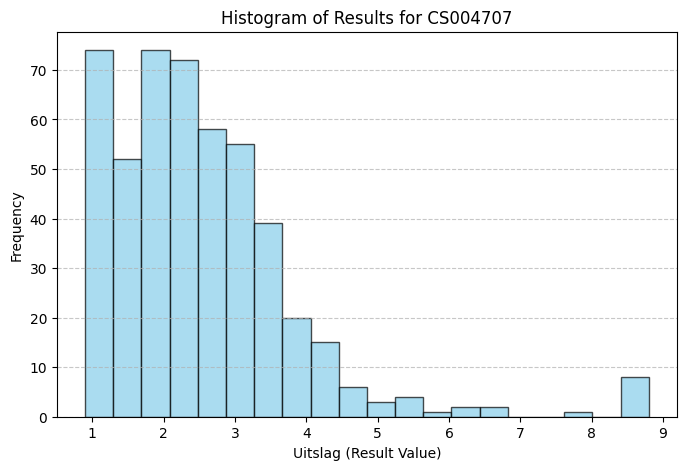

In [ ]:
# print histogram of the one code that we did not know
code = "CS004707"  # <-- Change this to your code

# Filter the data
subset = df_floats[df_floats["BepalingCode"] == code]

# Show unique Oms_Code(s) for that BepalingCode
print(f"Oms_Code(s) for BepalingCode {code}: {subset['Oms_Code'].unique()}")


try:
    numeric_results = pd.to_numeric(subset["Uitslag"], errors="coerce").dropna()
    if not numeric_results.empty:
        plt.figure(figsize=(8, 5))
        plt.hist(numeric_results, bins=20, color="skyblue", edgecolor="black", alpha=0.7)
        plt.title(f"Histogram of Results for {code}")
        plt.xlabel("Uitslag (Result Value)")
        plt.ylabel("Frequency")
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        plt.show()
    else:
        print(f"⚠️ No numeric results available for BepalingCode {code}.")
except Exception as e:
    print(f"Error plotting histogram: {e}")


In [78]:
# Drop rows
def drop_bepaling_codes(df, codes_to_drop):
    """
    Removes rows from the DataFrame where BepalingCode is in the given list.
    
    Parameters:
    - df: pandas DataFrame
    - codes_to_drop: list of BepalingCode values to remove
    
    Returns:
    - Filtered DataFrame
    """
    return df[~df["BepalingCode"].isin(codes_to_drop)]


In [79]:
codes_to_remove = [
    "CS004191", "CZE01303", "CS000301", "CZE01350", "CZE01351", "CZE01299",
    "CS000387", "CS000389", "CZE00538", "BBL000", "CS001132", "CZE00351",
    "CZE00365", "CZE01302", "CZE01279", "CS000309", "CS002768", "CS000306",
    "CS003406", "CZE00352", "CZE00366", "CS000483", "CS000542", "CZE01349",
    "CZE01893", "CS000530", "CZE00307"
]
df_floats = drop_bepaling_codes(df_floats, codes_to_remove)


In [ ]:
# Total number of rows in lab_data
total_rows = df_floats.shape[0]


# Count VT and Control patients
vt_count = df_floats[df_floats["PatID"].str.startswith("VT")]["PatID"].nunique()
control_count = df_floats[df_floats["PatID"].str.startswith("C")]["PatID"].nunique()
# Print results
print(f"Total rows in lab_data: {total_rows}")
print(f"Total unique patients: {unique_patients}")
print(f"VT patients: {vt_count}")
print(f"Control patients: {control_count}")

# Count unique test types
unique_tests = df_floats["Oms_Code"].nunique()

print(f"Total unique tests (Oms_Code): {unique_tests}")

Total rows in lab_data: 1355580
Total unique patients: 2771
VT patients: 111
Control patients: 2634
Total unique tests (Oms_Code): 144


In [82]:
df_floats.to_csv("final_data_modeling2.csv", index=False)

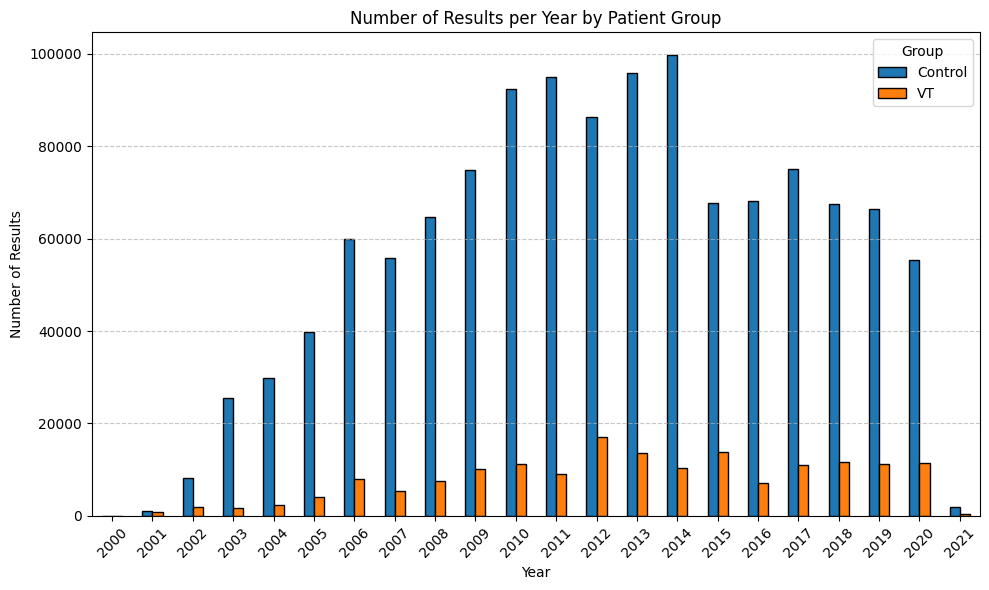

In [ ]:
df_floats["Date (s)"] = pd.to_datetime(df_floats["Date (s)"], errors='coerce')

# Drop rows where the date couldn't be parsed
df_floats = df_floats.dropna(subset=["Date (s)"])

# Extract year from the date
df_floats["Year"] = df_floats["Date (s)"].dt.year

# Count results per year per group 
year_group_counts = df_floats.groupby(["Year", "Group"]).size().unstack(fill_value=0)


year_group_counts.plot(kind="bar", figsize=(10, 6), edgecolor="black")
plt.title("Number of Results per Year by Patient Group")
plt.xlabel("Year")
plt.ylabel("Number of Results")
plt.xticks(rotation=45)
plt.legend(title="Group")
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()
